Let's look at our previous example of a nonlinear ODE:
$$
y'= y^2
$$
with $y(1)=-1$ with solution $y(t)=-\frac{1}{t}$. This is equivalent to following integral equation:
$$
y(t)= y(T) + \int_{T}^{t} y^{2}(s) ds
.
$$ 

To implement this we do slow recursion on $y(T)$ and fast recursion on the integral.

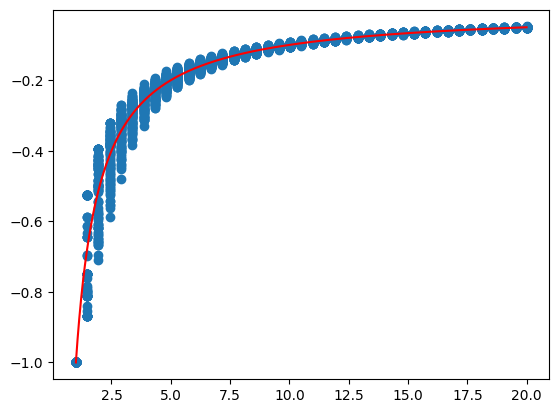

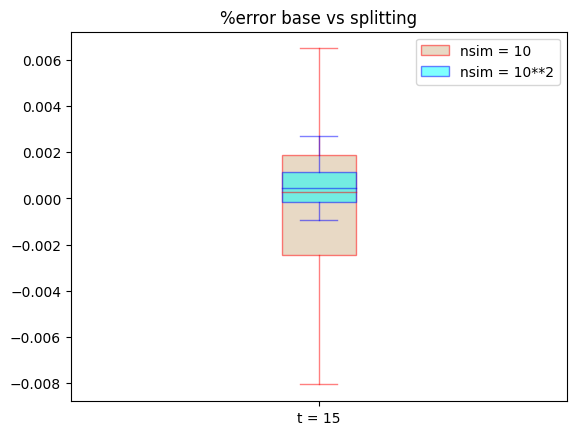

In [282]:
from random import random
import matplotlib.pyplot as plt
import numpy as np


def Y_fast(t, T, yT, DT):
    S = T + random()*(t-T)  # \sim Uniform(T,t)
    return yT + DT*Y_fast(S, T, yT, DT)*Y_fast(S, T, yT, DT) if random() < (t-T)/DT else yT


slow_points = []
def Y_slow(T, DT: "step size slow recursion"):
    TT = T-DT if T-DT > 1 else 1  # TT is where we are recursing to
    sol = Y_fast(T, TT, Y_slow(TT, DT), T-TT) if T > 1 else -1
    slow_points.append((T,sol))
    return sol


def pplot(T, n, nsim=10**2):
    s = sum(Y_slow(T, (T-1)/n) for _ in range(nsim))/nsim
    x,y = zip(*slow_points)
    xs = np.arange(1,T,0.01)
    z = [-1/l for l in xs]
    plt.scatter(x,y)
    plt.plot(xs,z,color = "red")
    plt.show()

pplot(20,40)

def split(T,DT,nsim=10**2):
    s= sum(Y_slow(T, DT) for _ in range(nsim))/nsim
    return (s+(1/T))*T

def box_plot(data, edge_color, fill_color):
    bp = ax.boxplot(data, patch_artist=True)
    for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp[element], color=edge_color, alpha = 0.5)
    for patch in bp['boxes']:
        patch.set(facecolor=fill_color)       
    return bp

DT = 0.3
n= 50
ts= [15]
data = [[split(t,DT,nsim = 10) for _ in range(n)] for t in ts]
data1 = [[split(t,DT,nsim = 10**2) for _ in range(n)] for t in ts]

fig, ax = plt.subplots()
bp1 = box_plot(data, 'red', 'tan')
bp2 = box_plot(data1, 'blue', 'cyan')
ax.legend([bp1["boxes"][0], bp2["boxes"][0]], ['nsim = 10', 'nsim = 10**2'])
plt.title("%error base vs splitting")
plt.xticks(ticks=[1],labels = [f"t = {t}" for t in ts])
#plt.ylim(-1,1)
plt.show()


The resulting estimator of RRMC is biased because the estimates in the inner recursion aren't independent ...

Lets do an other example:
$$
y' = y^{2} -t^{2} +1, y(0)=0.
$$ 
This has solution $y(t) = t$
Copy paste the previous implementation:

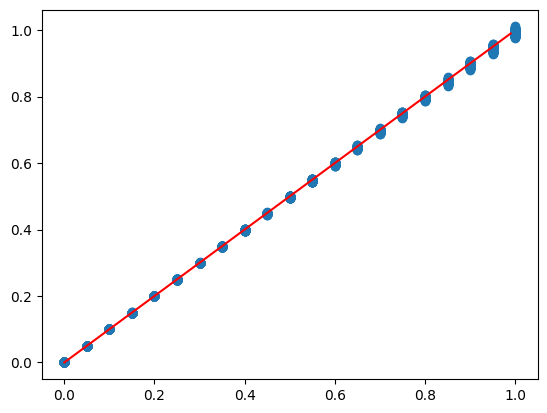

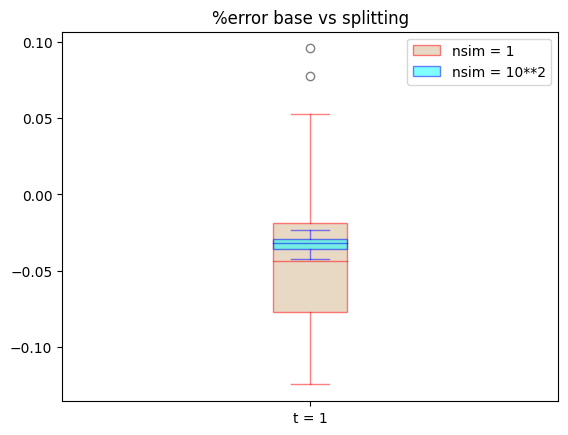

In [41]:
from random import random
import matplotlib.pyplot as plt
import numpy as np

def Y_fast(t, T, yT, DT):
    if random() > (t-T)/DT: return yT
    S = T + random()*(t-T)  # \sim Uniform(T,t)
    res = yT+ (T**3-t**3)/3 + t-T
    return res + DT*Y_fast(S, T, yT, DT)*Y_fast(S, T, yT, DT)  


slow_points = []
def Y_slow(T, DT: "step size slow recursion"):
    TT = T-DT if T-DT > 0 else 0  # TT is where we are recursing to
    sol = Y_fast(T, TT, Y_slow(TT, DT), T-TT) if T > 0 else 0
    slow_points.append((T,sol))
    return sol


def pplot(T, n, nsim=10**2):
    s = sum(Y_slow(T, T/n) for _ in range(nsim))/nsim
    x,y = zip(*slow_points)
    xs = np.arange(0,T,0.01)
    plt.scatter(x,y)
    plt.plot(xs,xs,color = "red")
    plt.show()

pplot(1,20)

def split(T,DT,nsim=10**2):
    s= sum(Y_slow(T, DT) for _ in range(nsim))/nsim
    return (s-T)/T 

def box_plot(data, edge_color, fill_color):
    bp = ax.boxplot(data, patch_artist=True)
    for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp[element], color=edge_color, alpha = 0.5)
    for patch in bp['boxes']:
        patch.set(facecolor=fill_color)       
    return bp

DT = 0.2
n= 50
ts= [1]
data = [[split(t,DT,nsim = 1) for _ in range(n)] for t in ts]
data1 = [[split(t,DT,nsim = 10**2) for _ in range(n)] for t in ts]

fig, ax = plt.subplots()
bp1 = box_plot(data, 'red', 'tan')
bp2 = box_plot(data1, 'blue', 'cyan')
ax.legend([bp1["boxes"][0], bp2["boxes"][0]], ['nsim = 1', 'nsim = 10**2'])
plt.title("%error base vs splitting")
plt.xticks(ticks=[1],labels = [f"t = {t}" for t in ts])
#plt.ylim(-1,1)
plt.show()

#bxp()

These simple tests shows that next flight has issues for nonlinear problems. This doesn't mean that it is impossible to solve nonlinear ODEs concurrently. We think it is possible by using a good modded russian roulette strategy in that it is possible to get unbiased estimates. 

Lets see how higher order RRMC does on nonlinear problems. Consider:
$$
y' = y^{2} - t^{4} +2t,y(0)=0.
$$ 
with solution: $y(t)=t^{2}$. With integral equation:
$$
y(t)= y(T) + \int_{T}^{t} y^{2}(s) ds - \frac{t^{5}-T^{5}}{5} +(t^{2}-T^{2}) .
$$ 
control variating $y^{2}(s)$ up to second order:
$$
\begin{align*}
y^{2}(t) &= y^{2}(T) + 2(t-T)y(T)y'(T) + ((t-T)y'(T))^{2} + O((t-T)^{2})\\
&= y^{2}(T) + 2(t-T)y(T)y'(T)+ O((t-T)^{2})
\end{align*}
$$ 
we could have kept the third term we think it would be more accurate but we're lazy. Then we have to integrate the control variate:

$$
\begin{align*}
   \int_{T}^{t} &y^{2}(T) + 2(s-T)y(T)y'(T) ds \\
   &= (t-T)y^{2}(T)+ 2\left(\frac{t^{2}-T^{2}}{2} -T(t-T) \right)y(T)y'(T)
\end{align*}
.
$$ 

In [69]:
from random import random
from math import exp,pow
import matplotlib.pyplot as plt
import numpy as np
from numba import njit, prange

@njit(fastmath=True)
def Y_fast(t, T, yT,dyT, DT):
    sol = yT # initial conditon
    sol += t**2-T**2 -(t**5-T**5)/5 # source  
    sol += (t-T)*yT**2 # 0 order control
    sol += 2*((t**2-T**2)/2 - T*(t-T))*yT*dyT # 1 order control
    l = 4 # >1 russian roulette parameter 
    if random()*l < (t-T)/DT:
        S = T + random()*(t-T)  # \sim Uniform(T,t)
        sol += l*DT*(Y_fast(S, T, yT, dyT, DT)*Y_fast(S, T, yT, dyT, DT) -yT**2-2*(S-T)*yT*dyT) 
    return sol 


@njit(fastmath=True)
def Y_slow(T, DT: "step size slow recursion"):
    y,t = 0,0
    while t<T:
        tt = t+DT if t+DT<T else T
        dy = y**2 -t**4+2*t 
        y = Y_fast(tt, t, y,dy, tt-t) 
        t=tt
    return y


@njit(fastmath=True, parallel=True)
def sol(T, DT, nsim ):
    total = 0.0
    for _ in prange(nsim):
        total += Y_slow(T,DT)
    return total/nsim

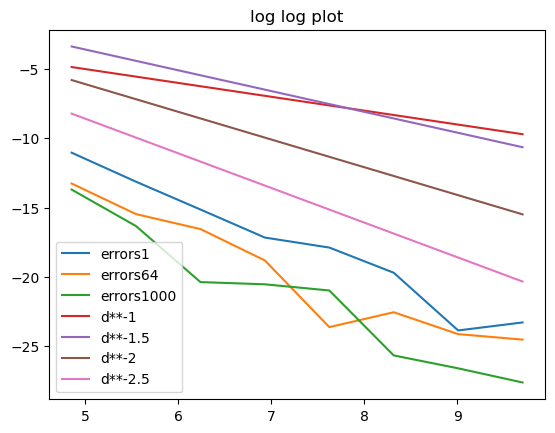

[1.60579614e-05 1.96976974e-06 2.64161523e-07 3.48440691e-08
 1.69457921e-08 2.74685062e-09 4.24661678e-11 7.56939093e-11]
[1.73008706e-06 1.89571344e-07 6.43741794e-08 6.67124463e-09
 5.40050857e-11 1.58150310e-10 3.25942291e-11 2.19048373e-11]
[1.11689613e-06 7.97691740e-08 1.39670826e-09 1.18995184e-09
 7.61821196e-10 6.98412521e-12 2.75129713e-12 9.89469138e-13]


In [70]:
T =0.9
def exact(t): return t**2
#DTS = np.array([0.1,0.01,0.001])
DTS = np.power(0.5,np.array(range(7,15)))
errors1 = np.array([(abs(sol(T, d, 1 )-exact(T)))/(exact(T)) for d in DTS])
errors64 = np.array([(abs(sol(T, d, 64 )-exact(T)))/(exact(T)) for d in DTS])
errors1000 = np.array([(abs(sol(T, d, 10**3 )-exact(T)))/(exact(T)) for d in DTS])
ref = np.array([d for d in DTS])
ref1 = np.array([pow(d,1.5)*50 for d in DTS])
ref2 = np.array([pow(d,2)*50 for d in DTS])
ref3 = np.array([pow(d,2.5)*50 for d in DTS])

plt.plot(-np.log(DTS),np.log(errors1), label = "errors1")
plt.plot(-np.log(DTS),np.log(errors64), label = "errors64")
plt.plot(-np.log(DTS),np.log(errors1000), label = "errors1000")
plt.plot(-np.log(DTS),np.log(ref),label ='d**-1')
plt.plot(-np.log(DTS),np.log(ref1), label="d**-1.5")
plt.plot(-np.log(DTS),np.log(ref2), label="d**-2")
plt.plot(-np.log(DTS),np.log(ref3), label="d**-2.5")
plt.legend()
plt.title("log log plot")
plt.show()

print(errors1)
print(errors64)
print(errors1000)

Ok no higher order of convergence, lets see just 0 order correction

In [62]:
from math import exp,pow
import matplotlib.pyplot as plt
import numpy as np
from numba import njit, prange

@njit(fastmath=True)
def Y_fast(t, T, yT, DT):
    sol = yT # initial conditon
    sol += t**2-T**2 -(t**5-T**5)/5 # source  
    sol += (t-T)*yT**2 # 0 order control
    l = 1 # >1 russian roulette parameter 
    if random()*l < (t-T)/DT:
        S = T + random()*(t-T)  # \sim Uniform(T,t)
        sol += l*DT*(Y_fast(S, T, yT, DT)*Y_fast(S, T, yT, DT)-yT**2 ) 
    return sol 


@njit(fastmath=True)
def Y_slow(T, DT: "step size slow recursion"):
    y,t = 0,0
    while t<T:
        tt = t+DT if t+DT<T else T
        y = Y_fast(tt, t, y, tt-t) 
        t=tt
    return y


@njit(fastmath=True, parallel=True)
def sol(T, DT, nsim ):
    total = 0.0
    for _ in prange(nsim):
        total += Y_slow(T,DT)
    return total/nsim

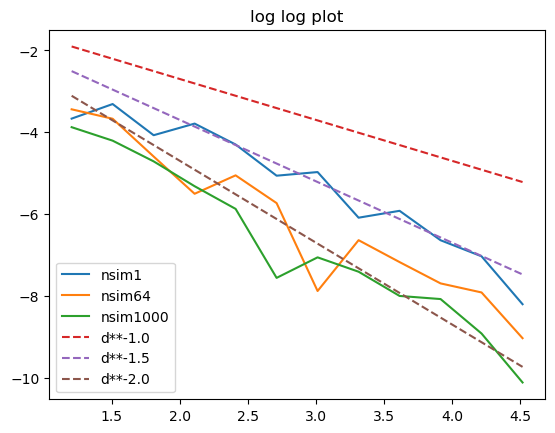

In [68]:
import matplotlib.pyplot as plt
import numpy as np

def nnRRMC_llplt():
    T = 0.5
    DTS = np.power(0.5,np.array(range(4,16)))
    Ns = [1,64,1000]
    for nsim in Ns:
        errors = np.array([(abs(sol(T, d, nsim )-T**2))/(T**2) for d in DTS])
        plt.plot(-np.log(DTS)/np.log(10),np.log(errors)/np.log(10), label = f"nsim{nsim}")

    dgs = np.arange(1,2.5,0.5)
    for l in dgs:
        ref = np.array([pow(d,l) for d in DTS])
        plt.plot(-np.log(DTS)/np.log(10),np.log(ref/5)/np.log(10),label =f"d**-{l}",linestyle="dashed")
    plt.legend()
    plt.title("log log plot")
    plt.show()

nnRRMC_llplt()

Here is classic RMC with a linear control variate to test that the half variance phenomenon happens with nonlinear problems:

In [39]:

from random import random
def Y(t,T):
    if t>2:
        raise Exception("this doesn't support higher t")
    u = random()*(t-1)+1
    return -1 + (T-1)*Y(u,T)*Y(u,T) if random()<(t-1)/(T-1) else -1 # Y(u)**2 != Y(u)*Y(u) !!!

nsim = 10**4
t = 1.5

def sol(t,nsim): return  sum(Y(t,t) for _ in range(nsim))/nsim

def error(t,nsim): return abs((sol(t,nsim)+1/t)*t)


print(error(t,nsim))

0.0016300924628971925


[3.40000000e-02 7.29277992e-03 1.57472237e-03 2.14206155e-04
 1.24826091e-04 3.97789214e-05 6.92923988e-06 1.30106375e-07
 5.94011771e-07 7.64051391e-08 5.52795956e-08 4.29083825e-09
 1.37147695e-09 2.53261349e-10 3.72538088e-11 3.72890884e-12
 5.11920546e-12 9.89216262e-13 6.11180107e-13 3.99681051e-14]


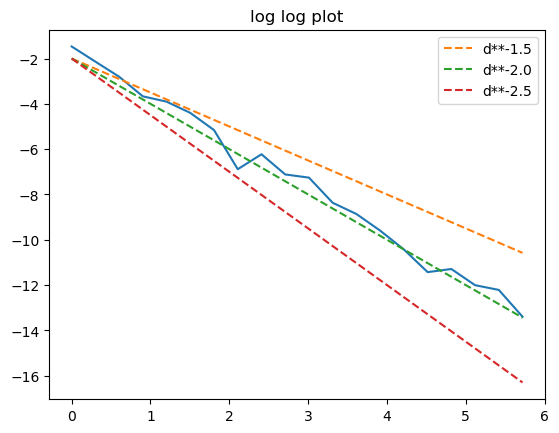

In [44]:
import matplotlib.pyplot as plt
import numpy as np

def nRRMC_llplt():
    TS = np.power(0.5,np.array(range(20)))
    nsim = 10**3
    errors = np.array([error(1+t,nsim) for t in TS])
    print(errors)
    plt.plot(-np.log(TS)/np.log(10), np.log(errors)/np.log(10))
    
    dgs = np.arange(1.5,3,0.5)
    for l in dgs:
        ref = np.array([pow(d,l) for d in TS])
        plt.plot(-np.log(TS)/np.log(10),np.log(ref/10**2)/np.log(10),label =f"d**-{l}",linestyle="dashed")
    plt.legend()
    plt.title("log log plot")
    plt.show()

nRRMC_llplt()

So the order of the local truncation order is $2$.